# Face Detection

## 1. Setup and Get Data

### 1.1 Install dependences

In [1]:
# ! pip install labelme tensorflow opencv-python matplotlib albumentations

In [2]:
# ! python.exe -m pip install --upgrade pip

### 1.2 Collecting imagec using OpenCV

In [3]:
import os, cv2
from uuid import uuid1
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [4]:
image_path = os.path.join('data', 'images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)

for image_num in range(number_images):
    print(f"img num: {image_num}")
    ret, frame = cap.read()
    image_name = os.path.join(image_path, f"{uuid1().hex}.jpg")

    cv2.imwrite(image_name, frame)
    cv2.imshow('frame', frame)
    sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

img num: 0
img num: 1
img num: 2
img num: 3
img num: 4
img num: 5
img num: 6
img num: 7
img num: 8
img num: 9
img num: 10
img num: 11
img num: 12
img num: 13
img num: 14
img num: 15
img num: 16
img num: 17
img num: 18
img num: 19
img num: 20
img num: 21
img num: 22
img num: 23
img num: 24
img num: 25
img num: 26
img num: 27
img num: 28
img num: 29


### 1.3 Annotating images using labelme

In [9]:
! labelme

2025-02-27 13:04:27.746 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\Shermukhammad\.labelmerc


## 2. Review Datset and build image loading function

### 2.1 Import Tensorflow and dependecies

In [5]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import json

### 2.2 Limit GPU memory grow

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [8]:
tf.test.is_built_with_cuda()

False

### 2.3 Load images to TF pipline

In [16]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [17]:
images.as_numpy_iterator().next()

b'data\\images\\159e19b4f4d711efa68f106838367566.jpg'

In [18]:
def load_image(image):
    byte_img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[220, 193, 146],
        [219, 192, 145],
        [218, 191, 146],
        ...,
        [ 50,  40,  31],
        [ 51,  40,  34],
        [ 55,  44,  38]],

       [[220, 193, 148],
        [219, 192, 147],
        [218, 191, 148],
        ...,
        [ 51,  41,  32],
        [ 52,  41,  35],
        [ 55,  44,  38]],

       [[220, 192, 152],
        [219, 191, 151],
        [218, 190, 150],
        ...,
        [ 55,  42,  34],
        [ 53,  42,  36],
        [ 54,  43,  37]],

       ...,

       [[234, 234, 224],
        [235, 235, 225],
        [236, 236, 226],
        ...,
        [126, 134, 136],
        [130, 135, 139],
        [130, 135, 139]],

       [[233, 233, 223],
        [234, 234, 224],
        [235, 235, 225],
        ...,
        [126, 131, 134],
        [127, 132, 136],
        [128, 133, 137]],

       [[234, 234, 224],
        [234, 234, 224],
        [235, 235, 225],
        ...,
        [122, 128, 128],
        [123, 128, 132],
        [123, 128, 132]]

In [21]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 3.4 View raw image using matplotlib

In [22]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_image = image_generator.next()

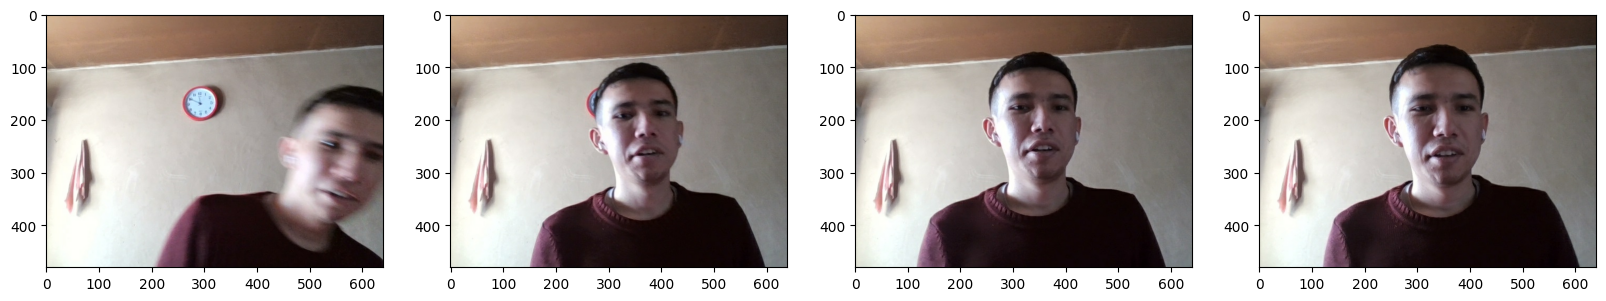

In [37]:
fig, ax =  plt.subplots(ncols=4, figsize = (20, 20))
for index, image in enumerate(plot_image):
    ax[index].imshow(image)

## 3. Spilt dat

### 3.1 Manuly split dat into train, test and validation set

In [82]:
80 * 1.5 # 120 to test

120.0

In [85]:
15 * 1.5 # 22 to test

22.5

In [86]:
5 * 1.5 # 8 to validation

7.5

### 3.2 Move lables to floders

In [88]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','lables', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'lables',filename)
            os.replace(existing_filepath, new_filepath) 

## 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [91]:
import albumentations as alb

In [92]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON